# Figure 4J-M

### Import packages

In [1]:
import ABCParse
import adata_query
import cellplots as cp
import larry
import matplotlib.pyplot as plt
import pandas as pd
import scdiffeq as sdq

from typing import Any, Dict, List, Optional

### Load data

Reference `adata`:

In [2]:
h5ad_path = "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
adata = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


Simulated `adata_sim`

In [3]:
h5ad_path = "./version_3/adata_19977.h5ad"
adata_sim = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 82000 × 50
    obs: 't', 'z0_idx', 'sim_i', 'sim', 'state', 'fate', 'drift', 'diffusion'
    uns: 'fate_counts', 'h5ad_path', 'sim_idx', 'simulated'
    obsm: 'X_diffusion', 'X_drift'


### Load PCA and Scaling model

In [4]:
PCA = sdq.io.read_pickle("/home/mvinyard/data/pca_model.pkl")
SCALER = sdq.io.read_pickle("/home/mvinyard/data/scaler_model.pkl")

### Annotate genes, scale predicted expression

In [5]:
sdq.tl.annotate_gene_features(adata_sim=adata_sim, adata=adata, PCA=PCA)
sdq.tl.invert_scaled_gex(adata_sim=adata_sim, scaler_model=SCALER)
X_gene_inv = adata_query.fetch(adata_sim, key="X_gene_inv", groupby=["fate", "t"])

 - [INFO] | Gene names added to: `adata_sim.uns['gene_ids']`
 - [INFO] | Inverted expression added to: `adata_sim.obsm['X_gene']`


### Compute mean and stdev expression by fate

In [6]:
mean_expr = pd.DataFrame(
    {group: group_df.mean() for group, group_df in X_gene_inv.items()}
)
std_expr = pd.DataFrame(
    {group: group_df.std() for group, group_df in X_gene_inv.items()}
)

In [32]:
def plot_smoothed_expression(
    mean_expr: pd.DataFrame,
    std_expr: pd.DataFrame,
    genes: List[str],
    fates: List[str],
    window: int = 5,
    cmap: Optional[Dict[str,str]] = None,
    ax: Optional[plt.Axes] = None,
    plot_kwargs: Optional[Dict[str, Any]] = {},
):
    
    input_ax = ax
    
    genes = ABCParse.as_list(genes)
    fates = ABCParse.as_list(fates)
    
    nplots = len(genes)
    
    if nplots <= 4:
        ncols = nplots
        
    _plot_kwargs = {
        "nplots": nplots,
        "ncols": ncols,
        "wspace": 0.2,
        "title": genes,
        "height": 0.5,
        "width": 0.5,
        "delete": [['top', 'right']]*nplots
    }
    _plot_kwargs.update(plot_kwargs)
    
    if input_ax is None:
        fig, axes = cp.plot(**_plot_kwargs)
    
    for en, gene in enumerate(genes):
        if input_ax is None:
            ax = axes[en]
        ax.grid(zorder=-10, alpha = 0.8, lw = 0.5)
        
        for ef, fate in enumerate(fates):
            gex_m = mean_expr[fate].T[gene]
            gex_s = std_expr[fate].T[gene]

            gex_m_sm = gex_m.rolling(window=window, center=True).mean()
            gex_s_sm = gex_s.rolling(window=window, center=True).mean()

            gex_m_sm[gex_m_sm.isna()] = gex_m[gex_m_sm.isna()]
            gex_s_sm[gex_s_sm.isna()] = gex_s[gex_s_sm.isna()]

            lo = gex_m_sm + gex_s_sm
            hi = gex_m_sm - gex_s_sm

            t = gex_m_sm.index
            if not cmap is None:
                color = cmap[fate]
            else:
                color = cm.tab20.colors[ef]
            ax.plot(gex_m_sm, zorder=25+en, label=fate, color=color)
            ax.fill_between(x=t, y1=lo, y2=hi, zorder=20+en, alpha=0.2, color=color, ec="None")
            ax.scatter(2, gex_m_sm.iloc[0], c = "k", s = 30, ec = "None", zorder = 30 + en)
            ax.scatter(6, gex_m_sm.iloc[-1], c = color, s = 30, ec = "None", zorder = 30 + en)

In [33]:
cmap = larry.pl.InVitroColorMap()._dict

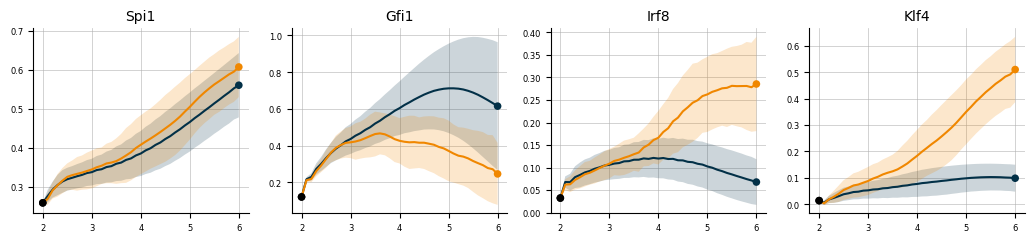

In [34]:
plot_smoothed_expression(
    mean_expr = mean_expr,
    std_expr = std_expr,
    genes = ['Spi1', 'Gfi1', 'Irf8', 'Klf4'],
    fates = ['Neutrophil', 'Monocyte'],
    cmap= cmap,
)
plt.savefig("Figure4JKLM.svg")